In [16]:
from pca_utils import *
from pca_mips import *
import time


In [5]:
def generate_data(
    num_atoms: int = 10**3,
    len_signal: int = 10**4,
    num_signals: int = 1,
    num_best_atoms: int =5,
    seed: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:

	
    rng = np.random.default_rng(seed)
    atoms_array = np.empty((num_atoms, len_signal))
    means = rng.normal(size=num_atoms)
    atoms_array = np.empty((num_atoms, len_signal))
    for idx in range(num_atoms):
      atoms_array[idx] = rng.normal(loc=means[idx], size=len_signal)
    signal = rng.normal(loc=rng.normal(), size=(num_signals, len_signal))
    if num_signals == 1:
        signal = signal.reshape(1,-1)

    return atoms_array, signal




In [153]:
def sample_complexity(dimension):
    delta = 2  # corresponds to the depth of PCA-tree
    top_k = 50

    atoms, signal = generate_data(num_atoms=1000, len_signal=dimension, num_best_atoms=top_k)
    
    pca_object = PCA_MIPS(delta=delta)
    W, mu = pca_object.preprocess_data(atoms)

    pca_object.preprocess_query(
        signal=signal,
        pca_matrix=W,
        mu=mu
    )
    start_time = time.time()
    candidates, budget = pca_object.run(top_k)
    timetaken = time.time() - start_time
    
    return timetaken

In [319]:
def precision_speed(delta):
    # delta = 2  # corresponds to the depth of PCA-tree
    top_k = 800

    atoms, signal = generate_data(num_atoms=1000, len_signal=100, num_best_atoms=top_k)
    
    pca_object = PCA_MIPS(delta=delta)
    W, mu = pca_object.preprocess_data(atoms)

    pca_object.preprocess_query(
        signal=signal,
        pca_matrix=W,
        mu=mu
    )
    start_time = time.time()
    candidates, budget = pca_object.run(top_k)
    timetaken = time.time() - start_time

    begin = time.time()
    naive_candidates_array = (
                    np.matmul(atoms, signal.transpose())
                    .argsort(axis=0)[:top_k]
                    .transpose()
                )
    naive_time = time.time() - begin 
    
    # print(naive_candidates_array)
    
    intersection = np.intersect1d(candidates, naive_candidates_array[0])
    precision = len(intersection)
    speedup = naive_time/timetaken
    
    return [precision, speedup]

In [318]:
delta = 4 # corresponds to the depth of PCA-tree
top_k = 40

import time

atoms, signal = generate_data(num_atoms=100, len_signal=100, num_best_atoms=top_k)

pca_object = PCA_MIPS(delta)
W, mu = pca_object.preprocess_data(atoms)

pca_object.preprocess_query(
    signal=signal,
    pca_matrix=W,
    mu=mu
)
start_time = time.time()
candidates, budget = pca_object.run(top_k)
timetaken = time.time() - start_time

print(f" =>> Top {top_k} candidates: ", sorted(candidates))
print(" =>> budget: ", budget)

 =>> Top 40 candidates:  [32, 37, 52, 61, 94, 99]
 =>> budget:  616


In [190]:
num_best_atoms =40

begin = time.time()
naive_candidates_array = (
                np.matmul(atoms, signal.transpose())
                .argsort(axis=0)[:num_best_atoms]
                .transpose()
            )
naive_time = time.time() - begin 

print(naive_candidates_array)

print(naive_time)

[[74 47 89 91 48 62 46 79 67 41 87 49 66 39 21 42 19 38 86 85 77 57 33 95
  53  7 24 44  6 55 71 94  5 43 78 72 68 96  2 50]]
0.014632463455200195


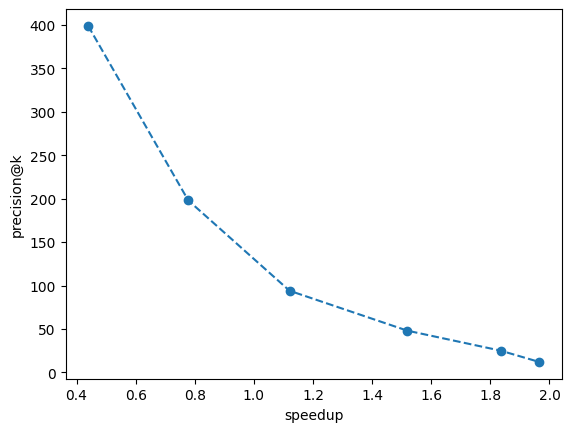

In [324]:
# plotting precision vs speedup tradeoff

pca_depth_list = [i for i in range(1,7)]
tradeoff_data  = []
for delta in pca_depth_list:
    tradeoff_data.append(precision_speed(delta))

tradeoff_data = np.array(tradeoff_data)
plt.plot(tradeoff_data[:,1],tradeoff_data[:,0], linestyle='--', marker='o')
plt.xlabel("speedup")
plt.ylabel("precision@k")

plt.show()

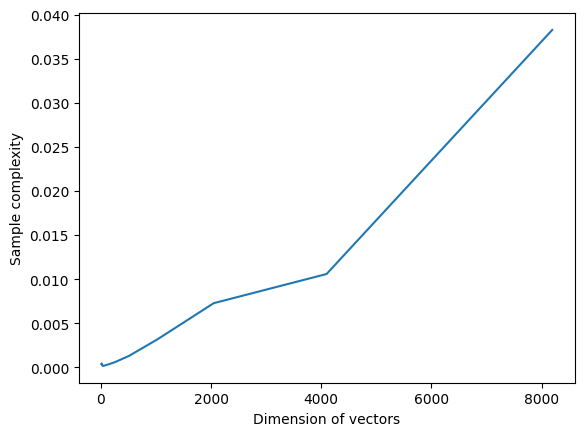

In [326]:
# plotting sample complexity plot

dimensions = [2**i for i in range(3,14)]
sample_comp  = []
for dimension in dimensions:
    sample_comp.append(sample_complexity(dimension))

plt.plot(dimensions,sample_comp)
plt.xlabel("Dimension of vectors")
plt.ylabel("Sample complexity")

plt.show()

Movie lens

In [18]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Load the MovieLens dataset (100k version for simplicity)
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_builtin('ml-1m')
trainset, testset = train_test_split(data, test_size=0.2)

# Build a user-item matrix
user_item_matrix = np.zeros((trainset.n_users, trainset.n_items))
for uid, iid, rating in trainset.all_ratings():
    user_item_matrix[int(uid), int(iid)] = rating

# Use SVD to reduce dimensionality
svd = TruncatedSVD(n_components=50)
atoms = svd.fit_transform(user_item_matrix.T)  # Transpose to get item embeddings

# Create a signal (simulate a user's preference vector)
user_id = 0  # Choose a user ID from the dataset
user_ratings = user_item_matrix[user_id]
signal = np.dot(user_ratings, atoms)  # Weighted average of rated item embeddings
signals = signal[np.newaxis, :]  # Ensure signal has 2D shape for batch processing
delta = 2
# Initialize Greedy MIPS parameters
budget = 10  # Number of candidates to screen
num_best_atoms = 10  # Top-k items to retrieve
top_k = 10
# Run PCA MIPS
candidates, sample_complexity = run_pca_mips(
                    atoms=atoms,
                    signals=signals,
                    num_best_atoms=num_best_atoms,
                    delta=delta,
                )

# Output results
print(f"Top {num_best_atoms} candidates (indices):\n{candidates[0]}")
print(f"Total complexity: {sample_complexity[0]}")

# Naive approach for validation
inner_products = np.dot(atoms, signal)
top_k_naive = np.argsort(inner_products)[-num_best_atoms:][::-1]
print(f"Top {num_best_atoms} candidates using naive approach (indices): {top_k_naive}")

# Compare results
accuracy = len(np.intersect1d(candidates[0], top_k_naive)) / num_best_atoms
print(f"Accuracy compared to naive method: {accuracy * 100:.2f}%")

# Compute speedup ratio
total_naive_computations = atoms.shape[0] * atoms.shape[1]
average_complexity = sample_complexity.mean()
speedup_ratio = total_naive_computations / average_complexity
print(f"Speedup ratio: {speedup_ratio:.2f} times faster than naive computation.")

NameError: name 'time' is not defined